In [210]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [211]:
# This function parse the ouput of PerkinElmer 
# Scan Array CSV File to find the start and end 
# of the output table
# It also find the cyanine 5 channel (CH1, CH2 or CH3)
# that contains
# the SH2 domain reading 
def parse_text(start_line='BEGIN DATA', 
               out_file_path=''):
    a=0
    start = 0
    end = 0
    for l in open(out_file_path):
        a+=1
        if l.startswith(start_line):
            start += a
        if l.startswith('END DATA'):
            end += a
        if 'Cyanine 5' in l:
            ch = l.split(',')[1]
            ch = ch.replace('H','h')
    return start, end, ch

In [212]:
out_file_path = os.path.join('data_file_post','714-49_BLK.csv')
start, end , ch = parse_text(out_file_path=out_file_path)
print(start, end , ch)

70 19272 Ch1


In [213]:
#now we can read an output file
df = pd.read_table(out_file_path, sep=',',
                   skiprows=start, engine ='python', 
                   skipfooter=1)
df.head()

,Index,Array Row,Array Column,Spot Row,Spot Column,Name,ID,X,Y,Diameter,...,Ch1 SD,Ch1 B Median,Ch1 B Mean,Ch1 B SD,Ch1 % > B + 1 SD,Ch1 % > B + 2 SD,Ch1 F % Sat.,Ch1 Median - B,Ch1 Mean - B,Ch1 SignalNoiseRatio
0,1,1,1,1,1,GNEPDKYPCNGQV,>Part3-5146,1775,5608,200,...,22.82,151,155,23.84,22.6,4.5,0.0,3,5,6.46
1,2,1,1,1,2,NLSQGGYEELERV,>Part3-5151,2007,5589,200,...,54.97,139,139,14.97,40.4,27.7,0.0,6,27,9.68
2,3,1,1,1,3,ALAAEGYYDIRRV,>Part3-5166,2229,5583,200,...,35.45,136,144,15.90,47.2,27.7,0.0,13,22,9.37
3,4,1,1,1,4,QHDEPCYWRLTRV,>Part3-5187,2463,5620,200,...,23.58,155,153,17.19,28.8,12.3,0.0,4,6,9.25
4,5,1,1,1,5,EAGKPIYSRYGSV,>Part3-5199,2675,5631,200,...,19.18,151,152,19.03,16.3,4.2,0.0,1,1,7.99


In [214]:
df.columns

Index(['Index', 'Array Row', 'Array Column', 'Spot Row', 'Spot Column', 'Name',
       'ID', 'X', 'Y', 'Diameter', 'F Pixels', 'B Pixels', 'Footprint',
       'Flags', 'Ch1 Median', 'Ch1 Mean', 'Ch1 SD', 'Ch1 B Median',
       'Ch1 B Mean', 'Ch1 B SD', 'Ch1 % > B + 1 SD', 'Ch1 % > B + 2 SD',
       'Ch1 F % Sat.', 'Ch1 Median - B', 'Ch1 Mean - B',
       'Ch1 SignalNoiseRatio'],
      dtype='object')

In [223]:
res = []
for n in df['ID']:
    try:
        res.append(int(n.split('-')[1].split(' ')[0]))
    except:
        res.append(np.nan)
df['sub_ID'] = res

In [224]:
#df['sub_ID'].value_counts()

# The array is composed of 3 identical blocks 
of 6400 spots, So that each spot on the array is repeated 3 times. The spots contains peptides or a controls (dye, Marker, GST...). A peptide can be spotted multiple times on the same block to control for reproducibility. For example, the peptides RVKEEGYELPYNP and GEEEHVYSFPNKQ are spotted 3 times in different position of the block.

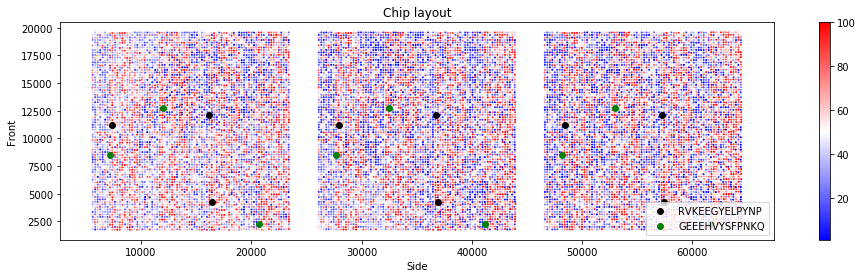

In [264]:
#create percentile of signal - background to color code intensity.
fig,ax=plt.subplots( figsize=(16,4),)
c= pd.qcut(df['Ch1 Mean - B'].rank(method='first'), 100, labels=np.arange(1,101) ).values
df.plot(x='Y', y='X',kind='scatter',s=1,
       c=c, colormap='bwr',ax=ax)

df[df['Name']=='RVKEEGYELPYNP'].plot(x='Y', y='X',
                                     kind='scatter', s=35, c='k',ax=ax,label='RVKEEGYELPYNP')
df[df['Name']=='GEEEHVYSFPNKQ'].plot(x='Y', y='X',
                                     kind='scatter', s=35, c='g',ax=ax,label='GEEEHVYSFPNKQ')

plt.title('Chip layout')
plt.xlabel('Side')
plt.ylabel('Front')
plt.legend()
plt.show()

# We can also visualize the background
to show experimental artifacts with antibody binding

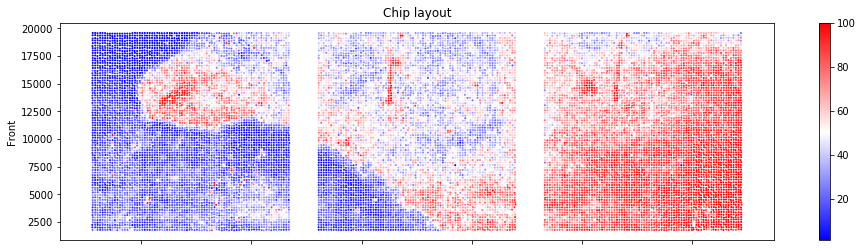

In [265]:
c= pd.qcut(df['Ch1 B Median'].rank(method='first'), 100, labels=np.arange(1,101) ).values
df.plot(x='Y', y='X',kind='scatter', figsize=(16,4), s=1,
       c=c, colormap='bwr')
plt.title('Chip layout')
plt.xlabel('Side')
plt.ylabel('Front')
plt.show()

# A problematic batch
anecdotally identified in the 714 chips, this batch is tagged Part3, with a number id greater than 4000.
This batch is responsible from some stripe patterns in the 714 chips

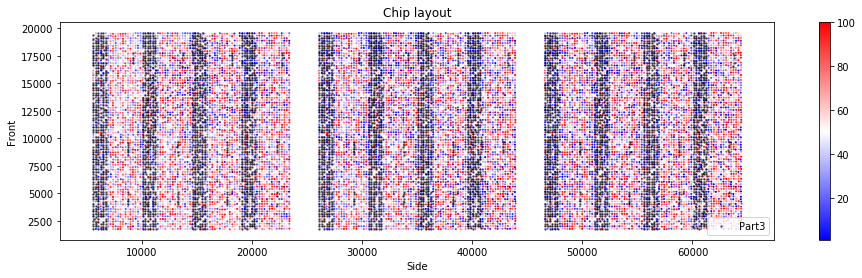

In [266]:
fig,ax=plt.subplots( figsize=(16,4),nrows=1,ncols=1)
c= pd.qcut(df['Ch1 Mean - B'].rank(method='first'), 100, labels=np.arange(1,101) ).values
df.plot(x='Y', y='X',kind='scatter',s=1,
       c=c, colormap='bwr',ax=ax)

df[ df.ID.str.contains('Part3') & (df['sub_ID']>4000)  ].plot(x='Y', y='X',kind='scatter', s=2,
       c='k',alpha=0.5,ax=ax,label='Part3')

plt.title('Chip layout')
plt.xlabel('Side')
plt.ylabel('Front')
plt.legend()
plt.show()

In [267]:
# this are probably the most useful columns 
# in the output file
suffixes = [' Median',' Mean',' SD',' B Median',
         ' B Mean',' B SD',' % > B + 1 SD',' % > B + 2 SD',
         ' F % Sat.',' Median - B',' Mean - B',' SignalNoiseRatio']
# to wich we add the peptide sequence and batch identifier
cols = ['Name','ID']+[ch + n for n in suffixes]
df = df[cols]
df.head()

,Name,ID,Ch1 Median,Ch1 Mean,Ch1 SD,Ch1 B Median,Ch1 B Mean,Ch1 B SD,Ch1 % > B + 1 SD,Ch1 % > B + 2 SD,Ch1 F % Sat.,Ch1 Median - B,Ch1 Mean - B,Ch1 SignalNoiseRatio
0,GNEPDKYPCNGQV,>Part3-5146,154,156,22.82,151,155,23.84,22.6,4.5,0.0,3,5,6.46
1,NLSQGGYEELERV,>Part3-5151,145,166,54.97,139,139,14.97,40.4,27.7,0.0,6,27,9.68
2,ALAAEGYYDIRRV,>Part3-5166,149,158,35.45,136,144,15.90,47.2,27.7,0.0,13,22,9.37
3,QHDEPCYWRLTRV,>Part3-5187,159,161,23.58,155,153,17.19,28.8,12.3,0.0,4,6,9.25
4,EAGKPIYSRYGSV,>Part3-5199,152,152,19.18,151,152,19.03,16.3,4.2,0.0,1,1,7.99


In [268]:
#some spots contains markers
df['Name'].value_counts().head(10)

<<Marker>>       384
pY                72
TAMRA             12
Triple Flaq       12
FITC              12
GST               12
IgG               12
IgM               12
PKEDPIYDEPEGL      9
GEEEHVYSFPNKQ      9
Name: Name, dtype: int64

In [269]:
# the peptides in the array where sintetised in
# different batches
df['batch']=[n.split('-')[0] for n in df['ID']]
df.groupby('batch').size()

batch
5198_1       72
5804_1       12
5804_2       12
>Jerini     753
>Part1      492
>Part2      804
>Part3     9273
SH2          12
none       7770
dtype: int64

In [280]:
# The processing of the data is arbitray. I can suggest:
# Median of the peptide replica replicated blocks
# and filter for 'Ch1 Median - B' > 0
temp = df.groupby('Name')['Ch1 Median - B'].median().sort_values(ascending = False)
temp[temp>0].head()

Name
ELQANCYEEVKDR    49574.0
LGTVMRYEEIELR    49061.0
TFNVDMYEEIHRK    45854.0
CTLWEAYANLHTA    43467.0
KFTSKEYEEIDKR    39903.0
Name: Ch1 Median - B, dtype: float64

In [282]:
temp[temp>0].tail()

Name
TATEGQYQQQP      1.0
TDFPGNYSGYDDA    1.0
DEAISDYFRKQYS    1.0
LHSKENYDKYSEP    1.0
EMGRDGYSDSEHY    1.0
Name: Ch1 Median - B, dtype: float64

In [283]:
# The files starting with different 
# nubers have a different layout of the 
# blocks: 816 and 811 have same layout that differs from 714
fnames = []
for fname in os.listdir('data_file_post'):
    if fname.endswith('csv'):
        fnames.append(fname.split('-')[0])
print(set(fnames))

{'816', '811', '714'}


In [ ]:
# chereoo 